In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('data/heart.csv')

train_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
## removing the outliers

#df1 = train_data[train_data['trestbps'] < (train_data['trestbps'].mean() + train_data['trestbps'].std()*3)]
#df2 = df1[df1['chol'] < (df1['chol'].mean() + df1['chol'].std()*3)]
#df3 = df2[df2['thalach'] < (df2['thalach'].mean() + df2['thalach'].std()*3)]
#df4 = df3[df3['oldpeak'] < (df3['oldpeak'].mean() + df3['oldpeak'].std()*3)]

#train_data = df4.copy()

In [4]:
#train_data.head()

In [5]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies] , axis=1)
        df = df.drop(column, axis=1)
    return df

In [30]:
def preprocess_inputs(df, scaler):
    df = df.copy()
    
    # One-hot encode the nominal features
    nominal_features = ['cp', 'slope', 'thal']
    df = onehot_encode(df, dict(zip(nominal_features, ['cp','slope','thal'])))

    X = df.drop('target', axis=1).copy()
    y = df['target'].copy()
     
    #Scale X
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y

In [31]:
X, y = preprocess_inputs(train_data, StandardScaler())

In [32]:
X.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,0.952197,0.681005,0.763956,-0.256334,2.394438,-1.005832,0.015443,-0.696631,1.087338,-0.714429,...,-0.444554,-0.634648,3.489114,3.664502,-0.926766,-0.939142,-0.081514,3.979112,-1.100763,-0.793116
1,-1.915313,0.681005,-0.092738,0.072199,-0.417635,0.898962,1.633471,-0.696631,2.122573,-0.714429,...,-0.444554,1.575677,-0.286606,3.664502,-0.926766,-0.939142,-0.081514,-0.251312,0.908461,-0.793116
2,-1.474158,-1.468418,-0.092738,-0.816773,-0.417635,-1.005832,0.977514,-0.696631,0.310912,-0.714429,...,2.249444,-0.634648,-0.286606,-0.272888,-0.926766,1.064802,-0.081514,-0.251312,0.908461,-0.793116
3,0.180175,0.681005,-0.663867,-0.198357,-0.417635,0.898962,1.239897,-0.696631,-0.206705,-0.714429,...,2.249444,-0.634648,-0.286606,-0.272888,-0.926766,1.064802,-0.081514,-0.251312,0.908461,-0.793116
4,0.290464,-1.468418,-0.663867,2.082050,-0.417635,0.898962,0.583939,1.435481,-0.379244,-0.714429,...,-0.444554,-0.634648,-0.286606,-0.272888,-0.926766,1.064802,-0.081514,-0.251312,0.908461,-0.793116


In [9]:
_X = torch.FloatTensor(X.values)
_y = torch.LongTensor(y.values)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(_X,_y,test_size=0.20)

In [11]:
X_train[0]

tensor([ 0.5110,  0.6810,  0.4784, -0.4882, -0.4176,  0.8990,  0.6277,  1.4355,
        -0.8969, -0.7144, -0.9454,  2.2494, -0.6346, -0.2866, -0.2729, -0.9268,
         1.0648, -0.0815, -0.2513,  0.9085, -0.7931])

In [12]:
y_train[0]

tensor(1)

In [13]:
class Model(nn.Module):
    
    def __init__(self, inp=21, h1=42, h2=20, out=2):
        super().__init__()
        
        self.f1 = nn.Linear(inp, h1)
        self.f2 = nn.Linear(h1, h2)
        #self.f3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h2, out)
        #self.dropout1 = nn.Dropout(0.2)
        #self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        
        x = F.relu(self.f1(x))
        #x = self.dropout1(x)
        x = F.relu(self.f2(x))
        #x = self.dropout2(x)
        #x = F.relu(self.f3(x))
        x = torch.sigmoid(self.out(x))
        
        return x

In [14]:
model = Model()
model

Model(
  (f1): Linear(in_features=21, out_features=42, bias=True)
  (f2): Linear(in_features=42, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)

In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
epochs = 300
losses = []

for i in range(epochs):
    
    i += 1
    
    y_predict = model.forward(X_train) ## predict using the model
    
    loss = loss_function(y_predict, y_train) ## calculate the loss
    
    losses.append(loss)
    
    if i%10==0:
        print(f'Epochs {i} ; Loss : {loss.item()}')
    
    optimizer.zero_grad() ## before update the weights, make it zero to remove remaining derivatives
    
    loss.backward() ## calculate the backward gradient
    
    optimizer.step() ## calculate the loss

Epochs 10 ; Loss : 0.5044553875923157
Epochs 20 ; Loss : 0.43525609374046326
Epochs 30 ; Loss : 0.4183676838874817
Epochs 40 ; Loss : 0.39879247546195984
Epochs 50 ; Loss : 0.3915696442127228
Epochs 60 ; Loss : 0.38970017433166504
Epochs 70 ; Loss : 0.38840818405151367
Epochs 80 ; Loss : 0.3880346417427063
Epochs 90 ; Loss : 0.3878435492515564
Epochs 100 ; Loss : 0.3845207989215851
Epochs 110 ; Loss : 0.38380858302116394
Epochs 120 ; Loss : 0.38371437788009644
Epochs 130 ; Loss : 0.38364100456237793
Epochs 140 ; Loss : 0.3836055397987366
Epochs 150 ; Loss : 0.3835807144641876
Epochs 160 ; Loss : 0.383503258228302
Epochs 170 ; Loss : 0.38000035285949707
Epochs 180 ; Loss : 0.37956687808036804
Epochs 190 ; Loss : 0.3794756531715393
Epochs 200 ; Loss : 0.3794401288032532
Epochs 210 ; Loss : 0.3794301450252533
Epochs 220 ; Loss : 0.37942105531692505
Epochs 230 ; Loss : 0.37941572070121765
Epochs 240 ; Loss : 0.3794120252132416
Epochs 250 ; Loss : 0.37940916419029236
Epochs 260 ; Loss : 0.3

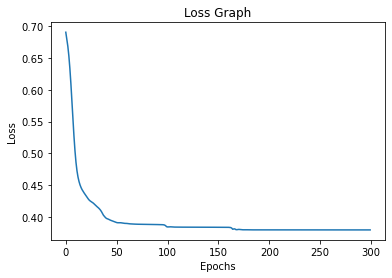

In [17]:
plt.plot(range(epochs), losses)
plt.title("Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [18]:
correct = 0

with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data)
        #print(f'Row:{i} \t {y_val} \t {y_val.argmax()} \t {y_test[i]}')
        
        if y_val.argmax() == y_test[i]:
            correct += 1

print(f'{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

51 out of 61 = 83.61% correct


In [19]:
with torch.no_grad():
    y_test_val = model.forward(X_test)
    loss = loss_function(y_test_val, y_test)

print(f'loss: {loss:.8f}')

loss: 0.47988018


In [20]:
torch.save(model.state_dict(),'model/medical-heart-pred-nn-20210717-2.pt')

## Predicting Test data

In [21]:
test_data = pd.read_excel('data/MedicalData_cts.xlsx', sheet_name='test', engine='openpyxl')

test_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,42,0,2,120,209,0,1,173,0,0.0,1,0,2,NaN
1,67,0,0,106,223,0,1,142,0,0.3,2,2,2,NaN
2,76,0,2,140,197,0,2,116,0,1.1,1,0,2,NaN
3,70,1,1,156,245,0,0,143,0,0.0,2,0,2,NaN
4,44,0,2,118,242,0,1,149,0,0.3,1,1,2,NaN


In [22]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       91 non-null     int64  
 1   sex       91 non-null     int64  
 2   cp        91 non-null     int64  
 3   trestbps  91 non-null     int64  
 4   chol      91 non-null     int64  
 5   fbs       91 non-null     int64  
 6   restecg   91 non-null     int64  
 7   thalach   91 non-null     int64  
 8   exang     91 non-null     int64  
 9   oldpeak   91 non-null     float64
 10  slope     91 non-null     int64  
 11  ca        91 non-null     int64  
 12  thal      91 non-null     int64  
 13  target    0 non-null      float64
dtypes: float64(2), int64(12)
memory usage: 10.1 KB


In [23]:
X_pred, _ = preprocess_inputs(test_data, StandardScaler())
X_pred.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,-1.506372,-1.825742,-0.757748,-0.724252,-0.408248,1.035314,1.411726,-0.790569,-1.071342,-0.872267,...,-0.351364,1.719454,-0.214423,-0.331295,0.827759,-0.666667,-0.105409,-0.214423,1.391217,-1.236033
1,1.219957,-1.825742,-1.542602,-0.438587,-0.408248,1.035314,-0.121176,-0.790569,-0.845492,0.891650,...,-0.351364,-0.581580,-0.214423,-0.331295,-1.208081,1.500000,-0.105409,-0.214423,1.391217,-1.236033
2,2.201436,-1.825742,0.363473,-0.969108,-0.408248,2.958040,-1.406836,-0.790569,-0.243224,-0.872267,...,-0.351364,1.719454,-0.214423,-0.331295,0.827759,-0.666667,-0.105409,-0.214423,1.391217,-1.236033
3,1.547117,0.547723,1.260449,0.010314,-0.408248,-0.887412,-0.071727,-0.790569,-1.071342,-0.872267,...,2.846050,-0.581580,-0.214423,-0.331295,-1.208081,1.500000,-0.105409,-0.214423,1.391217,-1.236033
4,-1.288265,-1.825742,-0.869870,-0.050899,-0.408248,1.035314,0.224963,-0.790569,-0.845492,0.009692,...,-0.351364,1.719454,-0.214423,-0.331295,0.827759,-0.666667,-0.105409,-0.214423,1.391217,-1.236033


In [29]:
new_model = Model()
new_model.load_state_dict(torch.load('model/medical-heart-pred-nn-20210717-2.pt'))
new_model.eval()

Model(
  (f1): Linear(in_features=21, out_features=42, bias=True)
  (f2): Linear(in_features=42, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)

In [28]:
X_pred_tensor = torch.FloatTensor(X_pred.values)

preds = []

with torch.no_grad():
    for i, data in enumerate(X_pred_tensor):
        predictions = new_model.forward(data).argmax()
        preds.append(predictions.detach().numpy())
    

result = pd.DataFrame({
    'age':test_data['age'],
    'sex': test_data['sex'],
    'cp': test_data['cp'],
    'trestbps': test_data['trestbps'],
    'chol': test_data['chol'],
    'fbs': test_data['fbs'],
    'restecg': test_data['restecg'],
    'thalach': test_data['thalach'],
    'exang': test_data['exang'],
    'oldpeak': test_data['oldpeak'],
    'slope': test_data['slope'],
    'ca': test_data['ca'],
    'thal': test_data['thal'],
    'target':preds
})
    
print(result[['age','target']])

#result.to_csv('data/result.csv', index=False)

    age target
0    42      0
1    67      1
2    76      1
3    70      1
4    44      0
..  ...    ...
86   59      1
87   64      1
88   47      1
89   57      0
90   57      0

[91 rows x 2 columns]


In [26]:
result['target'].sum()

44